# Machine Learning

In [1]:
import pandas as pd
import numpy as numpy
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


## Cargar datos limpios

In [3]:
# Cargar datos limpios
ratings_original = pd.read_csv(r"../data/process/rating.csv")

In [4]:
ratings_original["timestamp"] = pd.to_datetime(ratings_original["timestamp"])

In [5]:
YEAR_FILTER = ratings_original["timestamp"].dt.year.max()

In [6]:
YEAR_FILTER

np.int32(2015)

In [7]:
ratings = ratings_original[ratings_original["timestamp"].dt.year >= YEAR_FILTER]

In [8]:
movies = pd.read_csv(r"../data/process/movie.csv")

In [31]:
tags = pd.read_csv(r"../data/process/tag.csv")

In [32]:
tags["timestamp"] = pd.to_datetime(tags["timestamp"])

In [33]:
tags = tags[tags["timestamp"].dt.year >= YEAR_FILTER]

In [34]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19866 entries, 301 to 464452
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   userid     19866 non-null  int64         
 1   movieid    19866 non-null  int64         
 2   tag        19866 non-null  object        
 3   timestamp  19866 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 776.0+ KB


Comparacion de ratings original y el filtrado

In [ ]:
ratings_original.shape

(20000263, 4)

In [ ]:
ratings.shape

(283886, 4)

Obtenemos el numero de votos realizados por pelicula

In [ ]:
votos_por_pelicula = ratings.groupby('movieid')['rating'].agg('count').reset_index()
votos_por_pelicula.head()

,movieid,rating
0,1,437
1,2,164
2,3,24
3,4,6
4,5,38


In [ ]:
votos_por_pelicula.tail()

,movieid,rating
14634,131254,1
14635,131256,1
14636,131258,1
14637,131260,1
14638,131262,1


In [ ]:
fig_scatter = px.scatter(
    votos_por_pelicula,     # DataFrame (filtrado o completo)
    x='movieid',            # eje X
    y='rating',             # eje Y
    color='rating',         # colorear puntos según género
    size='rating',          # el tamaño del punto 
    hover_name='movieid', 
    title='Votos por pelicula',
    labels={
        "movieid": "Peliculas",
        "rating": "Votos",
    }
)
fig_scatter.show()

Obtenemos el numero de votos realizados por cada usuario

In [ ]:
votos_por_usuario = ratings.groupby('userid')['rating'].agg('count').reset_index()
votos_por_usuario.head()

,userid,rating
0,31,246
1,96,70
2,176,25
3,215,8
4,260,78


In [ ]:
fig_scatter = px.scatter(
    votos_por_usuario,     # DataFrame (filtrado o completo)
    x='userid',            # eje X
    y='rating',             # eje Y
    color='rating',         # colorear puntos según género
    size='rating',          # el tamaño del punto 
    hover_name='userid', 
    title='Votos por Usuarios',
    labels={
        "userid": "Usuarios",
        "rating": "Votos",
    }
)
fig_scatter.show()

# **Sistemas de Recomendación**
Los sistemas de recomendación son algoritmos que filtran y predicen las preferencias del usuario para sugerirle elementos (productos, películas, noticias, etc.) que probablemente le interesen.


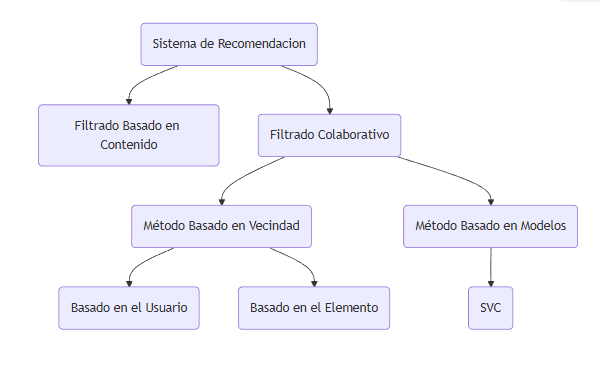


**¿Cómo funciona?** Pueden usar enfoques de filtrado colaborativo (basado en el comportamiento de usuarios similares), filtrado basado en contenido (basado en atributos del ítem) o una combinación híbrida para generar sugerencias personalizadas.

**Ejemplos de aplicación:**

- Recomendaciones de productos en plataformas de ecommerce (Amazon, Mercado Libre).
- Sugerencias de películas y series en servicios de streaming (Netflix, HBO Max).
- Personalización de noticias y artículos en plataformas de contenido (Google News, Facebook).
- Recomendaciones musicales (Spotify).

**Algoritmos comunes:** Filtrado Colaborativo (basado en usuario/ítem), Factorización Matricial (SVD, ALS), Modelos
basados en Redes Neuronales (Deep Learning), Algoritmos de Reglas de Asociación.

**Ventajas y casos de uso:** Mejoran la experiencia del usuario, aumentan el engagement y las ventas al presentar contenido relevante. Son omnipresentes en plataformas digitales y de comercio electrónico.

## Tecnicas a utilizar
- Filtrado colaborativo
   - Filtrado Colaborativo Basado en Vecindad
      
      A. Sistema de Recomendacion partiendo de usuario dado
      
         1. Generar una matriz de usuarios y peliculas
         2. Calcular la similitud entre usuarios usando la *similitud del coseno*
         3. Identificar las similitudes o parecidos por usuario determinado
         4. Probar recomendación colaborativa por usuario
         
      B. Sistema de Recomendacion partiendo de pelicula dada
      
         5. Union de dataframes ratings y movies
         6. Generar matriz de peliculas por rating de usuarios
         7. Cálculo de la Correlación

<!--    
- Reglas de asociación con **mlxtend**

   4. Transformar los tags por cada película en transacciones (una película 1:M un conjunto de tags). 
   5. Añadir una columna que especial por película para poder generar reglas como:"si tiene estos tags, entonces recomienda esta película".
   6. Se aplica el algoritmo `Apriori` para encontrar conjuntos frecuentes de tags + películas, y luego se generan reglas de asociación con métricas como lift y support.
   7. Dado un conjunto de tags de entrada, se filtran las reglas cuyos antecedentes los contienen y se extraen las películas recomendadas.
     -->

### Filtrado Colaborativo
#### 1.  Generar una matriz de usuarios y peliculas

In [ ]:
user_movie_matrix = ratings.pivot(index='userid', columns='movieid', values='rating').fillna(0)

In [ ]:
user_movie_matrix.head()

movieid,1,2,3,4,5,6,7,8,9,10,...,131241,131243,131248,131250,131252,131254,131256,131258,131260,131262
userid,,,,,,,,,,,,,,,,,,,,,
31,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_movie_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3903 entries, 31 to 138414
Columns: 14639 entries, 1 to 131262
dtypes: float64(14639)
memory usage: 435.9 MB


#### 2. Calcular KNN con similitud coseno sobre la matriz usuario-película. 

K-Nearest Neighbors (KNN) - Busqueda de vecinos mas cercanos 

- Vectores similares obtendran 1
- Vectores diferentes obtienen una puntuacion de 0

In [ ]:
user_sim = cosine_similarity(user_movie_matrix)
user_sim_df = pd.DataFrame(user_sim, index=user_movie_matrix.index, columns=user_movie_matrix.index)
user_sim_df

userid,31,96,176,215,260,279,284,318,342,370,...,138186,138187,138231,138271,138280,138299,138301,138380,138406,138414
userid,,,,,,,,,,,,,,,,,,,,,
31,1.000000,0.147473,0.157599,0.002983,0.067437,0.0,0.118751,0.303288,0.000000,0.055971,...,0.000000,0.074131,0.149830,0.120599,0.000000,0.113173,0.000000,0.243355,0.000000,0.036175
96,0.147473,1.000000,0.000000,0.000000,0.050610,0.0,0.070207,0.137240,0.059776,0.013512,...,0.000000,0.056989,0.031840,0.000000,0.000000,0.000000,0.000000,0.095542,0.000000,0.000000
176,0.157599,0.000000,1.000000,0.000000,0.016558,0.0,0.057756,0.074389,0.000000,0.000000,...,0.042267,0.000000,0.068316,0.140220,0.000000,0.000000,0.000000,0.083232,0.000000,0.000000
215,0.002983,0.000000,0.000000,1.000000,0.004451,0.0,0.000000,0.033986,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037755,0.000000,0.000000
260,0.067437,0.050610,0.016558,0.004451,1.000000,0.0,0.217583,0.171974,0.038453,0.029801,...,0.054069,0.414220,0.261567,0.206610,0.033877,0.016021,0.017214,0.226436,0.000000,0.055832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138299,0.113173,0.000000,0.000000,0.000000,0.016021,0.0,0.016755,0.056688,0.000000,0.000000,...,0.000000,0.058884,0.034022,0.041898,0.000000,1.000000,0.000000,0.082529,0.000000,0.000000
138301,0.000000,0.000000,0.000000,0.000000,0.017214,0.0,0.042681,0.050583,0.000000,0.000000,...,0.062774,0.111476,0.029593,0.000000,0.000000,0.000000,1.000000,0.068567,0.050762,0.000000
138380,0.243355,0.095542,0.083232,0.037755,0.226436,0.0,0.153991,0.282367,0.024664,0.098306,...,0.028311,0.245747,0.202340,0.166709,0.000000,0.082529,0.068567,1.000000,0.000000,0.049990


In [ ]:
# funcion para recomendar en funcion del usuario
def recommend_collaborative(userid, n=10):
    similar_users = user_sim_df[userid].sort_values(ascending=False).index[1:6]  # top 5 similares
    
    watched = set(ratings[ratings['userid'] == userid]['movieid'])
    candidates = ratings[ratings['userid'].isin(similar_users)]
    candidates = candidates[~candidates['movieid'].isin(watched)]
    recs = candidates.groupby('movieid')['rating'].mean().sort_values(ascending=False).head(n)
    return recs.index.tolist()

#### 3. Prueba de recomendación colaborativa por usuario

In [ ]:

# userid = ratings['userid'].iloc[0]
userid = 284
print(f"Recomendación colaborativa para usuario {userid}")
collab_recs = recommend_collaborative(userid, n=10)
print(collab_recs)

Recomendación colaborativa para usuario 284
[508, 1287, 1219, 1246, 2324, 6934, 7147, 4963, 6365, 7156]


In [ ]:
a = movies[movies["movieid"].isin(collab_recs)]
a

,movieid,title,genres
504,508,Philadelphia (1993),Drama
1193,1219,Psycho (1960),Crime|Horror
1218,1246,Dead Poets Society (1989),Drama
1259,1287,BenHur (1959),Action|Adventure|Drama
2239,2324,Life Is Beautiful (La Vita bella) (1997),Comedy|Drama|Romance|War
4867,4963,Ocean's Eleven (2001),Crime|Thriller
6260,6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6822,6934,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
7035,7147,Big Fish (2003),Drama|Fantasy|Romance
7044,7156,Fog of War Eleven Lessons from the Life of Rob...,Documentary|War


### B. Sistema de Recomendación partiendo de una pelicula dada

#### 5. Union de dataframes ratings y movies

In [ ]:
mov_user_df = pd.merge(ratings, movies, on="movieid", how="left")
mov_user_df.shape

(283886, 6)

In [ ]:
mov_user_df.head()

,userid,movieid,rating,timestamp,title,genres
0,31,1,3.0,2015-02-23 23:18:07,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,31,110,5.0,2015-02-23 23:17:53,Braveheart (1995),Action|Drama|War
2,31,260,5.0,2015-02-23 23:17:13,Star Wars Episode IV A New Hope (1977),Action|Adventure|Sci-Fi
3,31,364,3.0,2015-02-25 06:13:27,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
4,31,527,0.5,2015-02-23 23:19:58,Schindler's List (1993),Drama|War


#### 6. Generar matriz de peliculas por rating de usuarios

In [ ]:
mov_user_pv = mov_user_df.pivot_table(index = ["userid"],columns = ["title"],values = "rating").fillna(0)
mov_user_pv.head(5)

title,(Dollars) (1971),l'aventure (2008),'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Twas the Night Before Christmas (1974),"'burbs, The (1989)",(500) Days of Summer (2009),(Untitled) (2009),...,Zulu (1964),Zulu (2013),Zulu Dawn (1979),batteries not included (1987),eXistenZ (1999),iSteve (2013),loudQUIETloud A Film About the Pixies (2006),vegtigris (2001),xXx (2002),xXx State of the Union (2005)
userid,,,,,,,,,,,,,,,,,,,,,
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 7. Cálculo de la Correlación

In [ ]:
movie = mov_user_pv["BenHur (1959)"]

# Correlacion entre la pelicula y los usuarios
movie_corr = mov_user_pv.corrwith(movie)

In [ ]:
movie_corr = movie_corr.sort_values(ascending=False).reset_index()
movie_corr.head()

,title,0
0,BenHur (1959),1.000000
1,Spartacus (1960),0.363408
2,"20,000 Leagues Under the Sea (1954)",0.346524
3,"Treasure of the Sierra Madre, The (1948)",0.330237
4,"Right Stuff, The (1983)",0.306906


### Filtro Basado en Contenido

Obteniendo lista de Generos

In [36]:
genres = movies['genres'].str.split(pat='|', expand=True).fillna("")

In [148]:
unique_genres = set() # Usamos un set para guardar los géneros, ya que no permite duplicados

# Iteramos sobre cada fila del DataFrame
for index, row in genres.iterrows():
    for genre in row:
        if genre != '':
            genre = genre.replace(' ', '_')# Reemplaza espacios en blanco por _
            genre = genre.replace('-', '')# Reemplaza espacios en blanco por _
            genre = genre.replace(r'[^a-zA-Z0-9_]', '') # Reemplaza caracteres especiales
            unique_genres.add(genre)
            
unique_genres_list = list(unique_genres)
if '(no_genres_listed)' in unique_genres_list:
    unique_genres_list.remove('(no_genres_listed)')


unique_genres = pd.DataFrame({"genre": unique_genres_list})
unique_genres.reset_index(inplace=False)

unique_genres_list


['Thriller',
 'Mystery',
 'Horror',
 'Action',
 'Comedy',
 'Children',
 'FilmNoir',
 'Adventure',
 'Musical',
 'Romance',
 'IMAX',
 'Fantasy',
 'Drama',
 'Crime',
 'Western',
 'War',
 'Animation',
 'SciFi',
 'Documentary']

In [171]:
movies_proc = pd.read_csv(r"../data/process/procesados_movies.csv")

In [172]:
movies_proc.head(2)

,movieid,title,genres,no_genres_listed,Action,Adventure,Animation,Children,Comedy,Crime,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,3.672973,3.740781,3.766777,3.856772,3.861689,3.931421,3.946274,3.954945,3.860412,"Watched, computeranimation, Disneyanimatedfeat..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,2.923704,3.059659,3.044865,3.159884,3.178733,3.201903,3.266667,3.346552,3.128049,"timetravel, adaptedfrombook, boardgame, childh..."


In [198]:
movies_proc.columns

Index(['movieid', 'title', 'genres', 'no_genres_listed', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'FilmNoir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'SciFi', 'Thriller', 'War', 'Western', 'rating_promedio',
       'rating_conteo', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', 'tag'],
      dtype='object')

In [224]:
new_columns = unique_genres_list.copy()

In [225]:
new_columns.append("title")
new_columns.append("genres")
new_columns.append("rating_promedio")
new_columns

['Thriller',
 'Mystery',
 'Horror',
 'Action',
 'Comedy',
 'Children',
 'FilmNoir',
 'Adventure',
 'Musical',
 'Romance',
 'IMAX',
 'Fantasy',
 'Drama',
 'Crime',
 'Western',
 'War',
 'Animation',
 'SciFi',
 'Documentary',
 'title',
 'genres',
 'rating_promedio']

In [226]:
movies_dos = movies_proc[new_columns]

In [227]:
movies_dos.head(4)

,Thriller,Mystery,Horror,Action,Comedy,Children,FilmNoir,Adventure,Musical,Romance,...,Drama,Crime,Western,War,Animation,SciFi,Documentary,title,genres,rating_promedio
0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,Jumanji (1995),Adventure|Children|Fantasy,3.211977
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,Grumpier Old Men (1995),Comedy|Romance,3.151040
3,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393


In [ ]:
# for gn_field in unique_genres_list:
#     movies_dos.loc[movies_dos[gn_field] == 1, gn_field] = round(movies_dos["rating_promedio"],0)
    # movies_dos.loc[movies_dos[gn_field] == 0, gn_field] = round(0,1)
    # movies_dos.loc[movies_dos[gn_field] == 1, gn_field] = movies_dos["rating_promedio"]
    # movies_dos.loc[movies_dos[gn_field] == 0, gn_field] = round(0,1)

In [228]:
movies_dos.head(2)

,Thriller,Mystery,Horror,Action,Comedy,Children,FilmNoir,Adventure,Musical,Romance,...,Drama,Crime,Western,War,Animation,SciFi,Documentary,title,genres,rating_promedio
0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,1,0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,Jumanji (1995),Adventure|Children|Fantasy,3.211977


In [229]:
movies_dos.shape

(27278, 22)

In [230]:
X = movies_dos[unique_genres_list].values


In [220]:
X

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], shape=(27278, 19))

In [231]:
similarity_matrix = cosine_similarity(X)

In [232]:
def recommend_movies(movie_title, df, similarity_matrix, top_n=10):
    # Encuentra el índice de la película
    idx = df[df['title'] == movie_title].index
    if len(idx) == 0:
        print("Película no encontrada.")
        return None
    idx = idx[0]

    # Obtiene las similitudes para esa película
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Ordena por similitud (descendente), excluye la misma película
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Obtiene los índices de las películas recomendadas
    movie_indices = [i[0] for i in sim_scores]
    
    # Devuelve las películas recomendadas
    return df.iloc[movie_indices][['title', 'genres', 'rating_promedio']]


In [233]:
recomendaciones = recommend_movies("Toy Story (1995)", movies_dos, similarity_matrix, top_n=5)
print(recomendaciones)

                                               title  \
2209                                     Antz (1998)   
3027                              Toy Story 2 (1999)   
3663  Adventures of Rocky and Bullwinkle, The (2000)   
3922                Emperor's New Groove, The (2000)   
4790                           Monsters, Inc. (2001)   

                                           genres  rating_promedio  
2209  Adventure|Animation|Children|Comedy|Fantasy         3.303208  
3027  Adventure|Animation|Children|Comedy|Fantasy         3.841853  
3663  Adventure|Animation|Children|Comedy|Fantasy         2.261829  
3922  Adventure|Animation|Children|Comedy|Fantasy         3.580305  
4790  Adventure|Animation|Children|Comedy|Fantasy         3.879444  


In [234]:
def recommend_by_movie_id(movie_id, df, genre_cols, top_n=10):
    target = df[df['movieid'] == movie_id][genre_cols].values.reshape(1, -1)
    similarities = cosine_similarity(target, df[genre_cols].values).flatten()
    df['similarity'] = similarities
    return df[df['movieid'] != movie_id].nlargest(top_n, 'similarity')[['title', 'genres', 'rating_promedio']]

In [ ]:
movieid=1
rec = recommend_by_movie_id(movieid,movies_proc, unique_genres_list,10)
rec

,title,genres,rating_promedio
2209,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,3.303208
3027,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3.841853
3663,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,2.261829
3922,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,3.580305
4790,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,3.879444
10114,DuckTales The Movie Treasure of the Lost Lamp...,Adventure|Animation|Children|Comedy|Fantasy,3.335106
10987,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,2.653488
11871,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,3.084876
13337,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,3.122881
18274,Asterix and the Vikings (Astrix et les Vikings...,Adventure|Animation|Children|Comedy|Fantasy,3.279412


#### Recomendación por Género

In [245]:
def create_query_vector(target_genre, genres_list):
    vec = numpy.zeros(len(genres_list))
    if target_genre in genres_list:
        idx = genres_list.index(target_genre)
        vec[idx] = 1
    else:
        raise ValueError(f"Género '{target_genre}' no está en la lista.")
    return vec.reshape(1, -1)  # shape: (1, 19)

In [253]:
def recommend_by_genre(target_genre, movies_df, genres_list, top_n=10):
    # Vector de consulta
    query_vec = create_query_vector(target_genre, genres_list)
    
    # Matriz de características
    X = movies_df[genres_list].values
    
    # Similitud del coseno entre la consulta y todas las películas
    similarities = cosine_similarity(query_vec, X).flatten()
    
    # Añadir similitudes al DataFrame temporalmente
    movies_df_temp = movies_df.copy()
    movies_df_temp['similarity'] = similarities
    
    # Filtrar solo películas que tengan ese género (opcional, pero evita falsos positivos)
    # En teoría, solo las de ese género tendrán similitud > 0
    recommended = movies_df_temp[movies_df_temp[target_genre] == 1]
    
    # Ordenar por similitud (descendente) y luego por rating_promedio (para priorizar las mejor valoradas)
    recommended = recommended.sort_values(
        by=['similarity', 'rating_promedio', 'rating_conteo'],
        ascending=[False, False, False]
    ).head(top_n)
    
    return recommended[['title', 'genres']]

In [255]:
# Asigno un genero de la lista
# genero = unique_genres_list[3]
genero = "Adventure"

#Calculo dependiendo el genero
top_adventure = recommend_by_genre(genero, movies_proc, unique_genres_list, top_n=10)
print(top_adventure.reset_index())

   index                                              title     genres
0  24852                 Treasure of the Four Crowns (1983)  Adventure
1  21670                                  King Lines (2007)  Adventure
2  13536                                  Billy Budd (1962)  Adventure
3   5261                       Mountains of the Moon (1990)  Adventure
4  13466  Letter for the King, The (Brief voor de koning...  Adventure
5  15337                              The Black Rose (1950)  Adventure
6    924                          Mark of Zorro, The (1940)  Adventure
7   7093                      Wind and the Lion, The (1975)  Adventure
8  15620                             Treasure Island (1934)  Adventure
9  12791                             Black Swan, The (1942)  Adventure
